# Deep Learning with PyTorch - Tomas Beuzen

Working through some examples:

[https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter3_pytorch-neural-networks-pt1.html](https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter3_pytorch-neural-networks-pt1.html)



In [1]:
import sys
import numpy as np
import pandas as pd
import torch
from torchinfo import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Build a simple Linear Regression with a Neural Network

Use sklearn model as comparison:

In [3]:
X, y = make_regression(n_samples=500, n_features=1, random_state=0, noise=10.0)

sk_model = LinearRegression().fit(X, y)

print(f"w_0: {sk_model.intercept_:.2f} (bias/intercept)")
print(f"w_1: {sk_model.coef_[0]:.2f}")

w_0: -0.77 (bias/intercept)
w_1: 45.50


PyTorch version:

In [4]:
class linear_regression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out
            

In [5]:
model = linear_regression(input_size=1,
                         output_size=1,
                         )

In [6]:
print(model)

linear_regression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [7]:
summary(model, (1,))

Layer (type:depth-idx)                   Output Shape              Param #
linear_regression                        [1]                       --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [8]:
model.state_dict() # note that for now the weight and bias are initialized randomly so not meaningful

OrderedDict([('linear.weight', tensor([[0.9735]])),
             ('linear.bias', tensor([0.6349]))])

In [9]:
# convert the X,y data to tensors

X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

In [10]:
X_t.device, y_t.device, X_t.dtype, y_t.dtype

(device(type='cpu'), device(type='cpu'), torch.float32, torch.float32)

In [11]:
# get test output
y_example = model(X_t[0])

y_example, y_example.item(), y_t[0].item() # y_t[0] is actual value to be predicted

(tensor([1.2388], grad_fn=<ViewBackward0>),
 1.238809585571289,
 31.07604217529297)

In [12]:
LEARNING_RATE = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),
                           lr=LEARNING_RATE)

In [13]:
len(X_t)

500

In [14]:
# we'll make batch size = 50 -> 500/50 = 10 total batches therefore
BATCH_SIZE = 50

dataset = TensorDataset(X_t,
                       y_t)

dataloader = DataLoader(dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=True) # train dataloader so do shuffle

In [15]:
# test dataloader
print(next(iter(dataloader)))

[tensor([[ 0.6947],
        [-0.6635],
        [ 0.7733],
        [-0.4136],
        [ 0.6898],
        [-1.1731],
        [-0.5212],
        [-0.2677],
        [ 0.3792],
        [-0.3948],
        [-0.3090],
        [ 0.9473],
        [-0.4243],
        [-2.0164],
        [-0.3540],
        [-1.6170],
        [ 1.0777],
        [ 0.4960],
        [-0.2379],
        [-0.0422],
        [ 1.7327],
        [-0.0616],
        [ 0.3337],
        [ 0.4263],
        [-0.5395],
        [-2.5530],
        [-1.9808],
        [ 1.4694],
        [-0.7475],
        [-1.4241],
        [-0.3692],
        [ 0.2322],
        [-1.6139],
        [-0.9711],
        [ 0.0519],
        [-0.6510],
        [ 0.9433],
        [-0.2083],
        [ 0.4394],
        [ 0.1774],
        [ 0.1993],
        [-2.2556],
        [-0.5028],
        [ 0.1440],
        [-0.4534],
        [ 0.4628],
        [-1.4378],
        [ 1.5133],
        [-1.1044],
        [-2.6556]]), tensor([ 4.0259e+01, -2.6358e+01,  1.3572e+01, 

In [16]:
# -- TRAINING --

def trainer(model,
           criterion,
           optimizer,
           dataloader,
           epochs=5,
           verbose=True):
    for epoch in range(epochs):
        losses = 0
        for X, y in dataloader:
            optimizer.zero_grad() # clear gradients
            y_predictions = model(X).flatten() # forward pass
            loss = criterion(y_predictions, y) # calculate loss
            loss.backward() # backprop
            optimizer.step() # update parameters
            losses += loss.item() # add loss from this batch to the running total
        if verbose:
            print(f"- Epoch {epoch + 1} : loss = {losses / len(dataloader)}")

trainer(model,
       criterion,
       optimizer,
       dataloader,
       )
            



- Epoch 1 : loss = 643.1908752441407
- Epoch 2 : loss = 97.8449047088623
- Epoch 3 : loss = 93.54241027832032
- Epoch 4 : loss = 93.5164249420166
- Epoch 5 : loss = 93.79376068115235


In [17]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[45.6730]])),
             ('linear.bias', tensor([-0.9428]))])

In [18]:
# we note that our params are indeed different than they were before - how good are they compared to SKLEARN answer?

pd.DataFrame({"w0": [sk_model.intercept_, model.state_dict()['linear.bias'].item()],
              "w1": [sk_model.coef_[0], model.state_dict()['linear.weight'].item()]},
             index=['sklearn', 'pytorch']).round(2)

,w0,w1
sklearn,-0.77,45.50
pytorch,-0.94,45.67


In [19]:
# INTERESTING NOTE -- care! if you  run trainer() again, the model CONTINUES WHERE WE LEFT OFF
# since we didn't restart our model or optimizer

trainer(model,
       criterion,
       optimizer,
       dataloader,
       )
           

- Epoch 1 : loss = 93.6413516998291
- Epoch 2 : loss = 94.07207336425782
- Epoch 3 : loss = 94.15775413513184
- Epoch 4 : loss = 93.72869186401367
- Epoch 5 : loss = 93.78118858337402


# Multiple Linear Regression with a Neural Network

In [20]:
# Create dataset - WITH 3 FEATURES NOW 
X, y = make_regression(n_samples=500, n_features=3, random_state=0, noise=10.0)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
model = linear_regression(input_size=3,
                         output_size=1) # CARE! output size doesn't change ofc

In [22]:
summary(model, (3,))

#summary(model) # need to understand the difference with these options 

Layer (type:depth-idx)                   Output Shape              Param #
linear_regression                        [1]                       --
├─Linear: 1-1                            [1]                       4
Total params: 4
Trainable params: 4
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

trainer(model, criterion, optimizer, dataloader)

- Epoch 1 : loss = 1005.8968276977539
- Epoch 2 : loss = 112.91229782104492
- Epoch 3 : loss = 101.83285064697266
- Epoch 4 : loss = 102.23699111938477
- Epoch 5 : loss = 102.23942260742187


In [24]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[ 0.4658, 55.9662, 11.3502]])),
             ('linear.bias', tensor([0.3698]))])

In [25]:
# compare with sklearn
sk_model = LinearRegression().fit(X, y)
pd.DataFrame({"w0": [sk_model.intercept_, model.state_dict()['linear.bias'].item()],
              "w1": [sk_model.coef_[0], model.state_dict()['linear.weight'][0, 0].item()],
              "w2": [sk_model.coef_[1], model.state_dict()['linear.weight'][0, 1].item()],
              "w3": [sk_model.coef_[2], model.state_dict()['linear.weight'][0, 2].item()]},
             index=['sklearn', 'pytorch']).round(2)

,w0,w1,w2,w3
sklearn,0.43,0.62,55.99,11.14
pytorch,0.37,0.47,55.97,11.35


# Non-linear Regression with a Neural Network

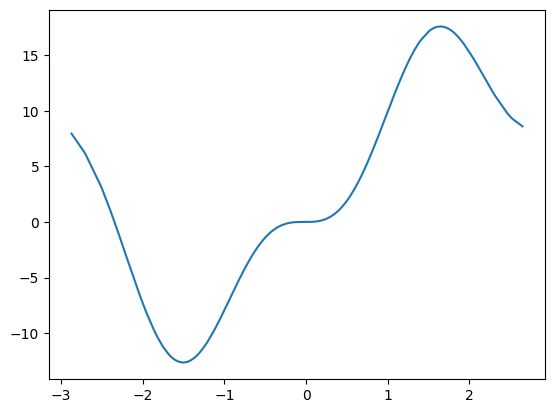

In [26]:
# Create dataset
np.random.seed(2020)
X = np.sort(np.random.randn(500))
y = X ** 2 + 15 * np.sin(X) **3

X_t = torch.tensor(X[:, None], dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

from matplotlib import pyplot as plt
plt.plot(X,y)
plt.show()

This is obviously non-linear, and we need to introduce some non-linearities into our network. These non-linearities are what make neural networks so powerful and they are called “activation functions”. We are going to create a new model class that includes a non-linearity - a sigmoid function

S(x) = 1 / (1 + exp(-x))

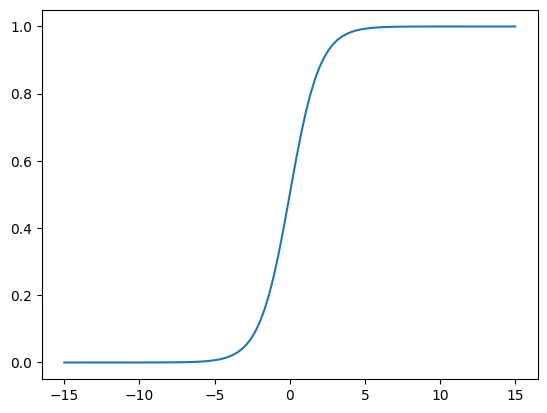

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

xs = np.linspace(-15, 15, 100)
plt.plot(xs, sigmoid(xs))
plt.show()

Create a network with 1 hidden layer of 3 neurons

2 ways of creating such a model :

## First way



In [28]:
class nonlinear_regression_first_approach(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)       # input -> hidden layer
        x = self.sigmoid(x)      # sigmoid activation function in hidden layer
        x = self.output(x)       # hidden -> output layer
        return x

## Second way - use nn.Sequential() to combine the layers together in the constructor itself

In [29]:
class nonlinear_regression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.main = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),  # input -> hidden layer
            nn.Sigmoid(),                        # sigmoid activation function in hidden layer
            nn.Linear(hidden_size, output_size)  # hidden -> output layer
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [30]:
model = nonlinear_regression(1, 3, 1)
summary(model, (1,))

Layer (type:depth-idx)                   Output Shape              Param #
nonlinear_regression                     [1]                       --
├─Sequential: 1-1                        [1]                       --
│    └─Linear: 2-1                       [3]                       6
│    └─Sigmoid: 2-2                      [3]                       --
│    └─Linear: 2-3                       [1]                       4
Total params: 10
Trainable params: 10
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [31]:
# -- TRAINING --
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
trainer(model, criterion, optimizer, dataloader, epochs=5, verbose=True)

- Epoch 1 : loss = 32.125611782073975
- Epoch 2 : loss = 14.104939603805542
- Epoch 3 : loss = 7.058206462860108
- Epoch 4 : loss = 5.733795714378357
- Epoch 5 : loss = 4.923586857318878


In [32]:
y_preds = model(X_t).detach().numpy().squeeze()

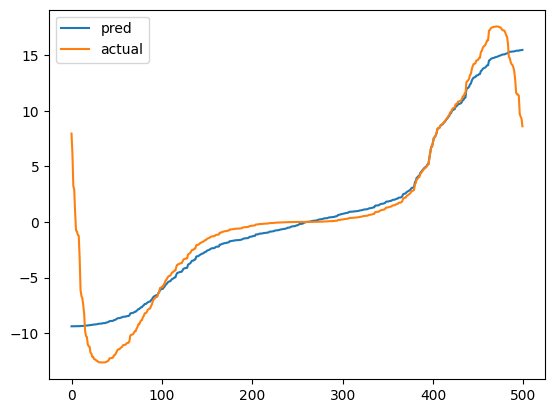

In [33]:
plt.plot(y_preds)
plt.plot(y)
plt.legend(["pred","actual"])
plt.show()

# Deep Learning

More than 1 hidden layer O_o

In [34]:
class deep_regression(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super().__init__()
        
        self.main = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                                 nn.Sigmoid(),
                                 nn.Linear(hidden_size_1, hidden_size_2),
                                 nn.Sigmoid(),
                                 nn.Linear(hidden_size_2, output_size),
                                 )
        
    def forward(self, x):
        return self.main(x)

In [35]:
model = deep_regression(1,5,3,1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.3)

trainer(model, criterion, optimizer, dataloader, epochs=20, verbose=True)



- Epoch 1 : loss = 60.03617935180664
- Epoch 2 : loss = 48.49238662719726
- Epoch 3 : loss = 28.935111808776856
- Epoch 4 : loss = 17.657272052764892
- Epoch 5 : loss = 21.14689416885376
- Epoch 6 : loss = 15.890552806854249
- Epoch 7 : loss = 14.101532173156738
- Epoch 8 : loss = 17.12859253883362
- Epoch 9 : loss = 9.231281113624572
- Epoch 10 : loss = 5.0990185141563416
- Epoch 11 : loss = 5.2867889404296875
- Epoch 12 : loss = 14.843407440185548
- Epoch 13 : loss = 5.121885514259338
- Epoch 14 : loss = 4.602397561073303
- Epoch 15 : loss = 6.5418975234031675
- Epoch 16 : loss = 4.315521156787872
- Epoch 17 : loss = 4.392490488290787
- Epoch 18 : loss = 5.661411643028259
- Epoch 19 : loss = 4.371110808849335
- Epoch 20 : loss = 5.136453986167908


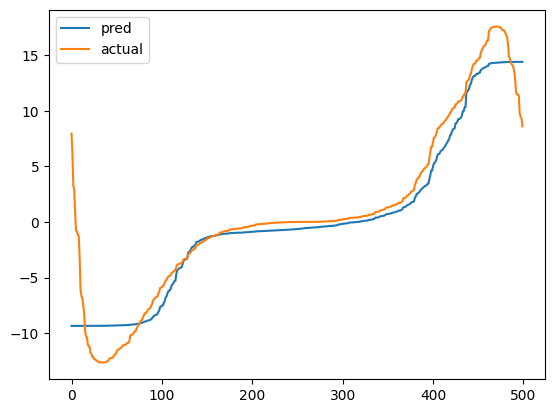

In [36]:
plt.plot(model(X_t).detach())
plt.plot(y)
plt.legend(["pred","actual"])
plt.show()

# Neural Network Classification

## Binary Classification

This will actually be the easiest part of the chapter. Up until now, we’ve been looking at developing networks for regression tasks, but what if we want to do binary classification? Well, what do we do in Logistic Regression? We just pass the output of a regression model into the Sigmoid function to get a value between 0 and 1 (a probability of an observation belonging to the positive class) - we’ll do the same thing here!

Let’s create a toy dataset:

In [37]:
X, y = make_circles(n_samples=300, factor=0.5, noise=0.1, random_state=2020)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# this is a circle within circle dataset of 2 different classes

Our model now needs to take 2 inputs (x1,x2 of each point in the 2d plane)

## note - we change to ReLU and Adam for optimizer from now on

we use log loss as criterion / loss function

**note - if you use BCELoss the formula expects a probability so you need to Sigmoid at the end of the network. HOWEVER: better practice to use BCEWithLogitsLoss which combines a Sigmoid and BCELoss but is numerically stable**

In [38]:
class binary_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.main = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
        )
        
    def forward(self, x):
        return self.main(x)

In [39]:
model = binary_classifier(2, 5, 1)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

trainer(model, criterion, optimizer, dataloader, epochs=20, verbose=True)

- Epoch 1 : loss = 0.6924566725889841
- Epoch 2 : loss = 0.6427271763483683
- Epoch 3 : loss = 0.5895505746205648
- Epoch 4 : loss = 0.5356595814228058
- Epoch 5 : loss = 0.5074167350927988
- Epoch 6 : loss = 0.46872543295224506
- Epoch 7 : loss = 0.41194258630275726
- Epoch 8 : loss = 0.3772290547688802
- Epoch 9 : loss = 0.319612555205822
- Epoch 10 : loss = 0.2804703662792842
- Epoch 11 : loss = 0.2616574987769127
- Epoch 12 : loss = 0.22613317022720972
- Epoch 13 : loss = 0.21982935319344202
- Epoch 14 : loss = 0.21078102538983026
- Epoch 15 : loss = 0.2043550709883372
- Epoch 16 : loss = 0.20528883983691534
- Epoch 17 : loss = 0.19301130870978037
- Epoch 18 : loss = 0.19049179429809251
- Epoch 19 : loss = 0.19000021368265152
- Epoch 20 : loss = 0.17849238589406013


To be clear, our model is just outputting some number between -∞ and +∞ (we aren’t applying Sigmoid in the model), so:

* To get the probabilities we would need to pass them through a Sigmoid;
* To get classes, we can apply some threshold (usually 0.5) to this probability.

For example, we would expect the point (0,0) to have a high probability and the point (-1,-1) to have a low probability **NOTE: bad choice of variables - 0,0 here means closes to the centre of the 2d plot, while -1,-1 just means "away from the inner circle" so close to the outer circle / 2nd class of points**

In [40]:
example_predictions = model(torch.tensor([[0, 0], [-1, -1]], dtype=torch.float32)).detach()
print(example_predictions)

tensor([[ 4.3586],
        [-8.9576]])


In [41]:
probability = nn.Sigmoid()(example_predictions)
print(probability)

tensor([[9.8737e-01],
        [1.2874e-04]])


In [42]:
classes = np.where(probability > 0.5, 1, 0) # use 0.5 threshold for classification here
print(classes)

[[1]
 [0]]


# Multiclass Classification

Same but with torch.nn.CrossEntropyLoss as criterion

In [43]:
class multi_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.main = nn.Sequential(nn.Linear(input_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, output_size),
                                 )
        
    def forward(self, x):
        return self.main(x)

In [44]:
# create 4 clusters/blobs in 2dimensions:

X, y = make_blobs(n_samples=200, centers=4, center_box=(-1.2, 1.2), cluster_std=[0.15, 0.15, 0.15, 0.15], random_state=12345)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.int64)
# Create dataloader
dataset = TensorDataset(X_t, y_t)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [45]:
model = multi_classifier(2, 5, 4) # 2inputs since x1,x2 in 2dim plane, then 4 outputs since 4 different clusters/blobs

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

# rewrite training loop (for practice O_o)

for epoch in range(10):
    losses = 0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_preds = model(X_batch)
        loss = criterion(y_preds, y_batch)
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f"Epoch {epoch+1} : loss = {losses / len(dataloader)}")

Epoch 1 : loss = 1.2824840247631073
Epoch 2 : loss = 0.6499357298016548
Epoch 3 : loss = 0.29380133002996445
Epoch 4 : loss = 0.15969141758978367
Epoch 5 : loss = 0.08289884310215712
Epoch 6 : loss = 0.04540144186466932
Epoch 7 : loss = 0.018003672128543258
Epoch 8 : loss = 0.01051791658392176
Epoch 9 : loss = 0.004493072454351932
Epoch 10 : loss = 0.004863672511419281


To be clear once again, our model is just outputting some number between -∞ and +∞, so:

* To get the probabilities we would need to pass them to a **Softmax**;
* To get classes, we need to select the largest probability.

For example, we would expect the point (-1,-1) to have a high probability of belonging to class 1, and the point (0,0) to have the highest probability of belonging to class 2.

In [46]:
example_prediction = model(torch.tensor([[-1, -1], [0,0]], dtype=torch.float32)).detach()
print(example_prediction)

tensor([[-19.5324,  17.6762,   2.8069, -43.3646],
        [-15.7309,  -0.0957,   7.4066, -13.4526]])


In [47]:
probability = nn.Softmax(dim=1)(example_prediction)
print(probability)

tensor([[6.9264e-17, 1.0000e+00, 3.4863e-07, 3.0925e-27],
        [8.9392e-11, 5.5154e-04, 9.9945e-01, 8.7245e-10]])


In [48]:
# predictions should now sum to 1
probability.sum(dim=1)

tensor([1., 1.])

In [49]:
# We can get the class with maximum probability using argmax()

classes = probability.argmax(dim=1)
print(classes)

tensor([1, 2])


# Notes from chapter 4 - Training Neural Networks

Has handwritten walkthrough of calculating backprop with chain rule, then introduces autograd:

Example NN has 1 hidden layer with 2 neurons and uses Sigmoid activation

In [50]:
class network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.hidden(x)
        x = torch.sigmoid(x)
        x = self.output(x)
        return x

In [51]:
model = network(1,2,1)
print(model.state_dict())

model.state_dict()['hidden.weight'][:] = torch.tensor([[1], [-1]])  # fix the weights manually based on the earlier figure
model.state_dict()['hidden.bias'][:] = torch.tensor([1, 2])
model.state_dict()['output.weight'][:] = torch.tensor([[1, 2]])
model.state_dict()['output.bias'][:] = torch.tensor([-1])

x, y = torch.tensor([1.0]), torch.tensor([3.0])  # our x, y data

OrderedDict([('hidden.weight', tensor([[-0.6521],
        [-0.5971]])), ('hidden.bias', tensor([ 0.4517, -0.5389])), ('output.weight', tensor([[0.6895, 0.5185]])), ('output.bias', tensor([0.4283]))])


Now let’s check the gradient of the bias of the output node:



In [52]:
print(model.output.bias.grad)


None


It’s currently None!

PyTorch is tracking the operations in our network and how to calculate the gradient (more on that a bit later), but it hasn’t calculated anything yet because we don’t have a loss function and we haven’t done a forward pass to calculate the loss so there’s nothing to backpropagate yet!

Let’s define a loss now:

In [53]:
criterion = torch.nn.MSELoss()



Now we can force Pytorch to “backpropagate” the errors, like we just did by hand earlier by:

* Doing a “forward pass” of our (x, y) data and calculating the loss;
* “Backpropagating” the loss by calling loss.backward()

In [54]:
loss = criterion(model(x), y)
loss.backward()  # backpropagates the error to calculate gradients!

Now let’s check the gradient of the bias of the output node

In [55]:
print(model.output.bias.grad)


tensor([-3.3142])


**this is the value calculated by hand earlier when you do the exercise, ok**

In [56]:
print("Hidden Layer Gradients")
print("Bias:", model.hidden.bias.grad)
print("Weights:", model.hidden.weight.grad.squeeze())
print()
print("Output Layer Gradients")
print("Bias:", model.output.bias.grad)
print("Weights:", model.output.weight.grad.squeeze())

Hidden Layer Gradients
Bias: tensor([-0.3480, -1.3032])
Weights: tensor([-0.3480, -1.3032])

Output Layer Gradients
Bias: tensor([-3.3142])
Weights: tensor([-2.9191, -2.4229])


Now that we have the gradients, what’s the next step? We use our optimization algorithm to update our weights! These are our current weights:

In [57]:
model.state_dict()


OrderedDict([('hidden.weight',
              tensor([[ 1.],
                      [-1.]])),
             ('hidden.bias', tensor([1., 2.])),
             ('output.weight', tensor([[1., 2.]])),
             ('output.bias', tensor([-1.]))])

To optimize them, we:

* Define an optimizer;
* Ask it to update our weights based on our gradients using optimizer.step().

In [58]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer.step()

Our weights should now be different:

In [59]:
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[ 1.0348],
                      [-0.8697]])),
             ('hidden.bias', tensor([1.0348, 2.1303])),
             ('output.weight', tensor([[1.2919, 2.2423]])),
             ('output.bias', tensor([-0.6686]))])

# Important note on clearing gradients

One last thing for you to know: Pytorch does not automatically clear the gradients after using them. So if I call loss.backward() again, my gradients accumulate:

In [60]:
optimizer.zero_grad()  # <- I'll explain this in the next cell
for _ in range(1, 6):
    loss = criterion(model(x), y)
    loss.backward()
    print(f"b3 gradient after call {_} of loss.backward():", model.hidden.bias.grad)

b3 gradient after call 1 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 2 of loss.backward(): tensor([-0.3983, -1.1953])
b3 gradient after call 3 of loss.backward(): tensor([-0.5974, -1.7929])
b3 gradient after call 4 of loss.backward(): tensor([-0.7966, -2.3906])
b3 gradient after call 5 of loss.backward(): tensor([-0.9957, -2.9882])


Our gradients are accumulating each time we call loss.backward()! So we need to tell Pytorch to “zero the gradients” each iteration using optimizer.zero_grad():

In [61]:
for _ in range(1, 6):
    optimizer.zero_grad()  # <- don't forget this!!!
    loss = criterion(model(x), y)
    loss.backward()
    print(f"b3 gradient after call {_} of loss.backward():", model.hidden.bias.grad)

b3 gradient after call 1 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 2 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 3 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 4 of loss.backward(): tensor([-0.1991, -0.5976])
b3 gradient after call 5 of loss.backward(): tensor([-0.1991, -0.5976])


## Computational graph

PyTorch’s autograd basically keeps a record of our data and network operations in a computational graph. That’s beyond the scope of this chapter, but if you’re interested in learning more, I recommend this excellent video. Also, torchviz is a useful package to look at the “computational graph” PyTorch is building for us under the hood:

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=7cc48ecd8ed180444d1dd220f2a356470a46dcab5c17d06c5f6c3a9aca326037
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


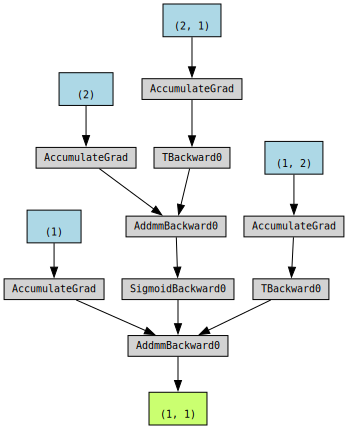

In [62]:
!pip install torchviz
from torchviz import make_dot
make_dot(model(torch.rand(1, 1)))

# Chapter 7 notes - advanced deep learning topics

## 1 Autoencoders

In [64]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets, utils, models
from torchinfo import summary
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
#from utils.plotting import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'axes.grid': False})

Example 1: Dimensionality Reduction

In [65]:
n_samples = 500
X, y = make_blobs(n_samples, n_features=2, centers=2, cluster_std=1, random_state=123)
X = np.concatenate((X, np.random.random((n_samples, 1))), axis=1)
X = StandardScaler().fit_transform(X)

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torchvision import utils
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold'})

In [70]:
def plot_scatter3D(X, y):
    fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2], mode='markers', marker=dict(size=4, color=y, colorscale='rdylbu'))])
    fig.update_layout(margin=dict(b=30, t=60), showlegend=False, scene=dict(
        zaxis=dict(title="X3"),
        yaxis=dict(title="X2"),
        xaxis=dict(title="X1"),
    )
    )
    return fig

In [71]:
plot_scatter3D(X, y)

We can see that X1 and X2 split the data nicely, and the X3 is just noise. The question is, can an AE learn that this data can be nicely separated in just two of the three dimensions?

Let’s build a simple AE with the following neurons in each layer: 3 -> 2 -> 3:

In [74]:
class autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.encoder = nn.Sequential(
        nn.Linear(input_size, 2),
        nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
        nn.Linear(2, input_size),
        nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        

In [75]:
BATCH_SIZE = 100
torch.manual_seed(1)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataloader = DataLoader(X_tensor,
                        batch_size=BATCH_SIZE)

model = autoencoder(3, 2) # NOTE !! ofc the inputdimension is 3 because points are in 3d : x1,x2,x3 etc.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [76]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(batch)
        loss = criterion(y_pred, batch)
        loss.backward()
        optimizer.step()
        


We only care about the encoder now, does it represent our data nicely in reduced dimensions?



In [77]:
model.eval()
print(f"Original X shape = {X_tensor.shape}")
X_encoded = model.encoder(X_tensor)
print(f" Encoded X shape = {X_encoded.shape}")

Original X shape = torch.Size([500, 3])
 Encoded X shape = torch.Size([500, 2])


In [78]:
def plot_scatter2D(X, y):
    fig = go.Figure(data=[go.Scatter(x=X[:,0].detach(), y=X[:,1].detach(), mode='markers', marker=dict(color=y, size=4, colorscale='rdylbu'))])
    fig.update_layout(width=500, height=400, margin=dict(b=30, t=60), showlegend=False
)
    fig.update_xaxes(title="Encoded feature 1", title_standoff=0)
    fig.update_yaxes(title="Encoded feature 2", title_standoff=0)
    return fig


In [79]:
plot_scatter2D(X_encoded, y)


What did we just do? We used an AE to effectively reduce the number of features in our data.



In [80]:
# this isn't in tutorial just me seeing what the decoder does O_o

X_decoded = model.decoder(X_encoded)
print(f" decoded X shape = {X_decoded.shape}")

 decoded X shape = torch.Size([500, 3])


In [82]:
plot_scatter3D(X_decoded.detach().numpy(), y)

## Example 2: Image Denoising

Okay, let’s do something more interesting. We saw above that AEs can be useful feature reducers (i.e., they can remove unimportant features from our data). This also applies to images and it’s a fun application to de-noise images!

Take a look at these images of 8’s from the MNIST dataset, I’m going to mess them up by adding some noise to them:

In [83]:
def plot_eights(X, noise=0.5):
    fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(7, 5))
    noise = noise * torch.randn(*X[1, 0, :, :].shape)
    ax1[0].imshow(X[1, 0, :, :], cmap="gray")
    ax2[0].imshow(X[1, 0, :, :] + noise, cmap="gray")
    ax1[1].imshow(X[2, 0, :, :], cmap="gray")
    ax1[1].set_title("Original 8's")
    ax2[1].imshow(X[2, 0, :, :] + noise, cmap="gray")
    ax2[1].set_title("Noisy 8's")
    ax1[2].imshow(X[3, 0, :, :], cmap="gray")
    ax2[2].imshow(X[3, 0, :, :] + noise, cmap="gray")
    plt.tight_layout();
    
    
def plot_eight_pair(input_8, output_8):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
    ax1.imshow(input_8.squeeze().detach(), cmap="gray")
    ax1.set_title("Input")
    ax2.imshow(output_8.squeeze().detach(), cmap="gray")
    ax2.set_title("Output")
    plt.tight_layout();

100%|██████████| 9912422/9912422 [00:00<00:00, 199827506.00it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35285666.71it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54112839.06it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

100%|██████████| 4542/4542 [00:00<00:00, 6842862.34it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



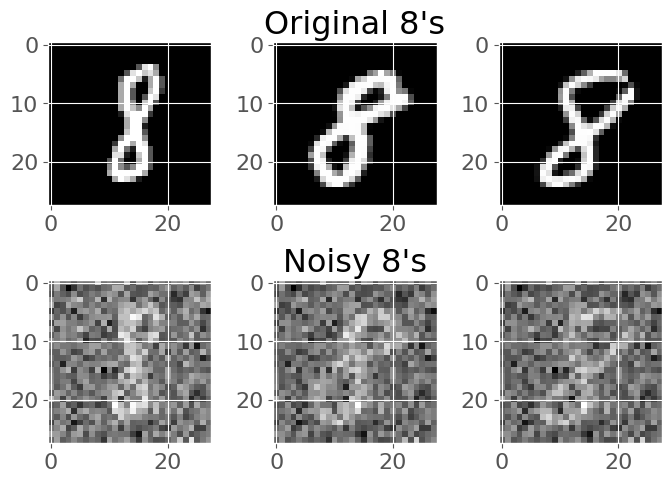

In [84]:
BATCH_SIZE = 32

# Download data
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)
idx = trainset.targets == 8  # let's only work with the number 8
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Sample plot
X, y = next(iter(trainloader))
noise = 0.5
plot_eights(X, noise)

Can we train an AE to get rid of that noise and reconstruct the original 8’s? Let’s give it a try!

I’m going to use convolutional layers in my AE now as we are dealing with images. We’ll use Conv2D() layers to compress our images into a reduced dimensonality, and then we need to “upsample” it back to the original size. One ingredient you’ll need to know to do this is “transposed convolutional layers”. These are just like “convolutional layers” but for the purpose of “upsampling” (increasing the size of) our data. Rather than simply expanding the size of our data and interpolating, we use nn.ConvTranspose2d() layers to help us learn how to best upsample our data:

In [85]:
# define a single convolution block
def conv_block(input_channels, output_channels):
    return nn.Sequential(
    nn.Conv2d(input_channels, output_channels, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2), # reduce x-y dims by 2; window and stride of 2
    )

# define a single deconvolution block using transposed convolutional layers
def deconv_block(input_channels, output_channels, kernel_size):
    return nn.Sequential(
    nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2),
    nn.ReLU(),
    )

In [86]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
        conv_block(1, 32),
        conv_block(32, 16),
        conv_block(16, 8),
        )
        
        self.decoder = nn.Sequential(
        deconv_block(8, 8, 3),
        deconv_block(8, 16, 2),
        deconv_block(16, 32, 2),
        nn.Conv2d(32, 1, 3, padding=1), # final conv layer to decrease channel back to 1
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x) # get pixels between 0 and 1
        return x

So we want to train our model to remove that noise I added. Generally speaking, the idea is that the model learns what pixel values are important, we are reducing the dimensionality of the imaages, so our model must learn only the crucial information (i.e., not the noise) needed to reproduce the image. Right now, our model probably produces gibberish because it isn’t trained:

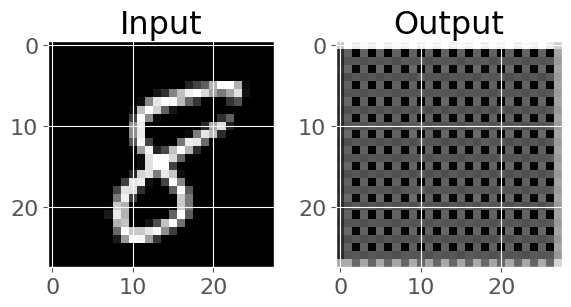

In [88]:
model = AutoEncoder()
input_8 = X[:1, :1, :, :]
output_8 = model(input_8)
plot_eight_pair(input_8, output_8)

How do we train it? Well we feed in a noisy image, compare it to the non-noisy version, and let the network learn how to make that happen. We want the value of the predicted pixels to be as close as possible to the real pixel values, so we’ll use MSELoss() as our loss function:

In [90]:
EPOCHS = 20
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
img_list = []

for epoch in range(EPOCHS):
    losses = 0
    for batch, _ in trainloader:
        noisy_batch = batch + noise * torch.randn(*batch.shape)
        noisy_batch = torch.clip(noisy_batch, 0.0, 1.0)
        optimizer.zero_grad()
        y_hat = model(noisy_batch)
        loss = criterion(y_hat, batch)
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f"epoch: {epoch + 1}, loss: {losses / len(trainloader):.4f}")
    # Save example results each epoch so we can see what's going on
    with torch.no_grad():
        noisy_8 = noisy_batch[:1, :1, :, :]
        model_8 = model(input_8)
        real_8 = batch[:1, :1, :, :]
    img_list.append(utils.make_grid([noisy_8[0], model_8[0], real_8[0]], padding=1))

epoch: 1, loss: 0.1068
epoch: 2, loss: 0.0521
epoch: 3, loss: 0.0436
epoch: 4, loss: 0.0412
epoch: 5, loss: 0.0395
epoch: 6, loss: 0.0381
epoch: 7, loss: 0.0367
epoch: 8, loss: 0.0355
epoch: 9, loss: 0.0346
epoch: 10, loss: 0.0337
epoch: 11, loss: 0.0331
epoch: 12, loss: 0.0325
epoch: 13, loss: 0.0319
epoch: 14, loss: 0.0316
epoch: 15, loss: 0.0311
epoch: 16, loss: 0.0308
epoch: 17, loss: 0.0304
epoch: 18, loss: 0.0302
epoch: 19, loss: 0.0298
epoch: 20, loss: 0.0296


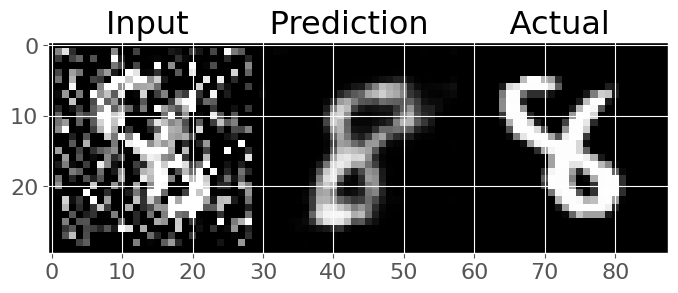

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title("Input        Prediction        Actual")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('eights.gif', writer='imagemagick', fps=2)


In [94]:
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

# here there is an exercise working through DCGAN generative adverserial network

but i don't understand the fake vs real data part of code so read it elsewhere (example is nice though, and shows how you can initialize weights in model - you do .apply(my_weight_init_function) to instance of model: the init function involves doing stuff like "if x isintance(nn.conv2d) ... " so you check based on type of layer it seems etc

In [95]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

# model.apply(weights_init)